<a href="https://colab.research.google.com/github/Not-Will-S/Credit-Card-Prediction/blob/main/EnsembleDeepLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: Y, Length: 30000, dtype: int64
Epoch 1/18
26/26 [==============================] - 3s 41ms/step - loss: 12252.0332 - accuracy: 0.5671 - val_loss: 21.0792 - val_accuracy: 0.7851
Epoch 2/18
26/26 [==============================] - 1s 32ms/step - loss: 34.7549 - accuracy: 0.6144 - val_loss: 0.5897 - val_accuracy: 0.7409
Epoch 3/18
26/26 [==============================] - 1s 32ms/step - loss: 1.7788 - accuracy: 0.5878 - val_loss: 0.6901 - val_accuracy: 0.7851
Epoch 4/18
26/26 [==============================] - 1s 31ms/step - loss: 1.4855 - accuracy: 0.5836 - val_loss: 0.6375 - val_accuracy: 0.7778
Epoch 5/18
26/26 [==============================] - 1s 30ms/step - loss: 1.2885 - accuracy: 0.5860 - val_loss: 0.5617 - val_accuracy: 0.7569
Ep

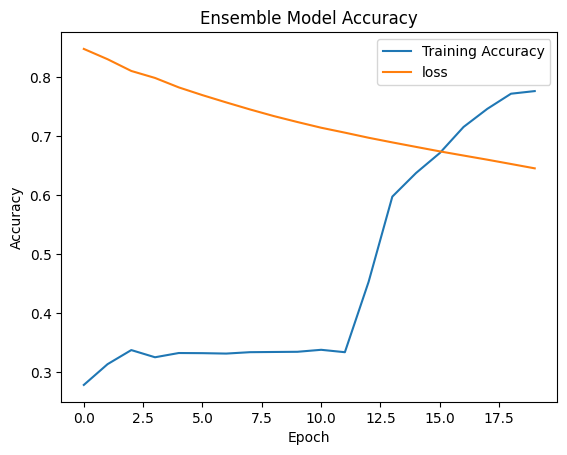

In [ ]:
import keras
from __future__ import print_function
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, LSTM, Reshape, Input, Concatenate
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical, custom_object_scope
from google.colab import drive
from collections import Counter
import keras.backend as K
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

#-------------------Importing data-----------------------------

data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/CCD.xls') #read in the data
data = data.drop(0) #Remove the record descriptions
Y = data['Y']  # Target variable is Y
Y = data['Y'].astype(int)  # Convert to int
print(Y)
X = data.drop('Y', axis=1).astype(float)  # This will add all the data from the excel file apart from the target catagory to the variable X



#----------------------Data preprocessing------------------------------
MLP_features_names = ['X1', 'X2', 'X3', 'X3', 'X4', 'X5']
MLP_features = data[MLP_features_names].astype(float) #features to be analysed by the MLP

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15) # creates a test train split for the MLP model
X_train_MLP = X_train[MLP_features_names].astype(float)
X_val_MLP = X_val[MLP_features_names].astype(float)

sequence_length = 6 #Declares how long the sequence is for the RNN
features_to_analyse = 1

RNN1_features_names = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17'] # Decalres the features for the first RNN
RNN2_features_names = ['X18', 'X19', 'X20', 'X21', 'X22', 'X23'] # Declares the features for the second RNN
X_train_RNN1 = X_train[RNN1_features_names].astype(float) # reshapes the training data for the first RNN
X_val_RNN1 = X_val[RNN1_features_names].astype(float)
X_train_RNN2 = X_train[RNN2_features_names].astype(float)
X_val_RNN2 = X_val[RNN2_features_names].astype(float)

X_train_RNN1 = X_train_RNN1.to_numpy() #Reshapes the training data so that it can be used in the first RNN
X_train_RNN1 = X_train_RNN1.reshape(X_train_RNN1.shape[0], sequence_length, features_to_analyse).astype(float)
X_val_RNN1 = X_val_RNN1.to_numpy()
X_val_RNN1 = X_val_RNN1.reshape(X_val_RNN1.shape[0], sequence_length, features_to_analyse).astype(float)

X_train_RNN2 = X_train_RNN2.to_numpy() #Reshapes the training data so that it can be used in the second RNN
X_train_RNN2 = X_train_RNN2.reshape(X_train_RNN2.shape[0], sequence_length, features_to_analyse).astype(float)
X_val_RNN2 = X_val_RNN2.to_numpy()
X_val_RNN2 = X_val_RNN2.reshape(X_val_RNN2.shape[0], sequence_length, features_to_analyse).astype(float)




class_weights={0: 1, 1: 2.5} # declares class weights to be used later


#----------------MLP model Creation------------------------



model = keras.Sequential([ # Defines the sequentiall MLP model that will be trained
  keras.layers.Dense(300, activation='relu', input_shape=(X_train_MLP.shape[1],)),
  keras.layers.Dropout(rate=0.1), #Dropout to avoid overfitting
  keras.layers.Dense(300, activation='relu'),
  keras.layers.Dense(150, activation='relu'),
  keras.layers.Dropout(rate=0.01), #Dropout to avoid overfitting
  keras.layers.Dense(150, activation='relu'),
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate =0.015) # Assigns the learning rate for the model
model.compile(loss='binary_crossentropy', # compliles the MLP
              optimizer=optimizer,
              metrics=['accuracy'],
              )

MLP_history = model.fit(X_train_MLP, Y_train, epochs=18, batch_size=1000, class_weight=class_weights, # Trains the first MLP based on the hyperparams specified
                    validation_data=(X_val_MLP, Y_val))


#------------------------Recursive Models Creation-----------------------

RNN_model = Sequential()
RNN_model.add(LSTM(units=32, return_sequences=True, input_shape=(sequence_length, features_to_analyse)))
RNN_model.add(LSTM(units=4))
RNN_model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
RNN_model2 = RNN_model

optimizer = Adam(learning_rate = 0.0001) # defines the learning rate
RNN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # compiles the RNN

RNN1_history = RNN_model.fit(X_train_RNN1, Y_train, epochs=20, batch_size=1000, class_weight=class_weights, validation_data=(X_val_RNN1, Y_val)) #Trains the first RNN model
RNN2_history = RNN_model2.fit(X_train_RNN2, Y_train, epochs=20, batch_size=1000, class_weight=class_weights, validation_data=(X_val_RNN2, Y_val)) # Trains the seconds RNN model based on different data

model.summary()
RNN_model.summary()
RNN_model2.summary()

#Makes predictions based on the training for each model
mlp_predictions =  model.predict(X_train_MLP)
rnn1_predictions = RNN_model.predict(X_train_RNN1)
rnn2_predictions = RNN_model2.predict(X_train_RNN2)



# Split the predictions and target variable (Y) for the MLP model
mlp_predictions_train, mlp_predictions_test, = train_test_split(
    mlp_predictions, test_size=0.15, random_state=42
)

# Split the predictions  for the RNN1 model
rnn1_predictions_train, rnn1_predictions_test = train_test_split(
    rnn1_predictions, test_size=0.15, random_state=42
)

# Split the predictions for the RNN2 model (using the already split Y_test)
rnn2_predictions_train, rnn2_predictions_test = train_test_split(
    rnn2_predictions, test_size=0.15, random_state=42
)


#----------------------------------------Ensemble model creation ------------------------------------------


# Define separate input layers for each model's output
mlp_input = Input(shape=(1))
rnn1_input = Input(shape=(1))
rnn2_input = Input(shape=(1))


ensemble_inputs = Input(shape=(3,))

combined = Dense(4, activation='relu')(ensemble_inputs) # creates the ensemble model
combined = Dropout(rate=0.2)(combined) # dropout to avoid overfitting
ensemble_output = Dense(1, activation='sigmoid')(combined)

stacked_model = Model(inputs=ensemble_inputs, outputs=ensemble_output)

stacked_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # compiles the model



combined_predictions = np.concatenate([mlp_predictions, rnn1_predictions, rnn2_predictions], axis=1) # Combines the preditions into one tuple so the models can be trained

history = stacked_model.fit(combined_predictions, Y_train, epochs=20, batch_size=2000) # trains the model based on the paramaters

combined_predictions_test = np.concatenate([mlp_predictions_test, rnn1_predictions_test, rnn1_predictions_test], axis=1) # tests the model to see the accuracy

Y_val_reduced = Y_val[:3825] # reduces the size of the Y validation set to match the testing data
stacked_loss, stacked_accuracy = stacked_model.evaluate(combined_predictions_test, Y_val_reduced)
print("Stacked Loss:", stacked_loss)
print("Stacked Accuracy:", stacked_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy') # plots a graph based on the training of the model
plt.plot(history.history['loss'], label='loss')
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()












